# ***Nowcasting de la actividad económica en Antioquia (IMSEA) usando modelos de factores dinámicos***

---
Proyecto Antioquia Analítica

# **Programación del algortimo IMSEA - IMSEM**

**Autores:** Equipo Nowcast del proyecto Antioquia Analitica


Marzo 10 de 2021

El código de programa del Nowcasting Antioquia (IMSEA) en lenguaje Python que es código abierto y libre, incluso se puede ejecutar en Google Colab, por consiguiente, puede replicarse sin necesidad de instalación.

El IMSEA se crea considerando los co-movimientos en trece (13) variables macroeconómicas en Antioquia y Colombia (la información es de fácil acceso y público, están disponibles en el DANE, en el portal de XM, la OECD, y del Banco de la República; el ID de la serie que se usa a continuación se da entre paréntesis).


***Datos Macroeconómicos para el departamento de Antioquia***

Del DANE:

Indicador de Seguimiento a la Economía de la Industria (ISE)

Indice de Producción Real Nacional (IPI)

Indice de Ventas Reales Nacional (Ventas)

Empleados en la industria (EMP)

Despachos de cemento gris Antioquia (cem)
- Obras civiles, vivienda y edificaciones

Indice de producción real Antioquia

Licencias de construcción Antioquia (lic)

Exportaciones de Antioquia (Exp)

Importaciones de Antioquia (Imp)

Del Portal XM:

Demanda de energía SIN (ener)

Demanda de energía comercial no regulada (ener2)

De la OECD:

índice de confianza industrial (ICI)

De la encuesta de expectativas económicas:

índices de la industria


En todos los casos, los datos tienen una frecuencia mensual y sin el ajustado estacionalmente; el período considerado es 2007-2020.

uso de la librería statsmodels v0.12.0.dev0 de Python.


# **Paso 1: Importando las librerías de Python a utilizar (los códigos están en cursiva y negrilla, el # se usa para los comentarios de los códigos del algoritmo).**

In [200]:
# Nuestro primer paso importar las librerías a utilizar
%matplotlib inline  
# Solo dibuja imágenes estáticas en el cuaderno
# %matplotlib notebook

# Importando la librería de matrices
import numpy as np
# Importando la librería de datos
import pandas as pd
# Importando la librería de gráficos
import matplotlib.pyplot as plt

# Librería especializada en modelos estadísticos
import statsmodels.api as sm

np.set_printoptions(precision=4, suppress=True, linewidth=120)
# Precisión: Número de dígitos de precisión para salida de coma flotante
# Suprimir: Suprime la impresión de valores de punto flotante pequeños utilizando notación científica

En esta ocasión se utiliza la base de datos DANE:

Fundamentalmente la Encuesta Mensual Manufacturera

[ISE-DANE](https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/indicador-de-seguimiento-a-la-economia-ise)

[DANE-Industria](https://www.dane.gov.co/)

[XM-Energía](http://portalbissrs.xm.com.co/Paginas/Home.aspx)

[Encuesta mensual de expectativas económicas (EMEE)](https://www.banrep.gov.co/es/expectativas-economicas-empresarios-mensual)

# **Paso 2: Importando los datos consignados en una hoja de Excel que se encuentra en el power point y es llamada “Antioquia.xlsx” y que contiene varias hojas.**

In [201]:
# Obtener los datos de DANE
start = '2007-01-01'   # Periodo mensual de inicio
end = '2020-12-01'     # Periodo mensual final

# Variables de interés
import pandas as pd
datos=pd.read_excel('Antioquia.xlsx','data')

# La hoja bd2a contiene las series originales con frecuencia mensual

## Se utilizan las variables de mayores correlaciones dinámicas

ise = datos['ISE']                             # Indicador de Seguimiento a la Economía de Colombia
ipi = datos['IPR']                             # Indicador de Seguimiento a la Economía de Antioquia
ventas2 = datos['IVR']                         # Indice de producción industrial para Colombia
ventas = datos['IET']                          # Indice de producción industrial para las ventas
emp2 = datos['per']                            # Indice de producción industrial para el empleo
emp = datos['isea']                            # Importaciones
a = datos['isep']                              # Indicador de Seguimiento a la Economía primario
b = datos['ises']                              # Indicador de Seguimiento a la Economía secundario
c = datos['iset']                              # Indicador de Seguimiento a la Economía terciario
d = datos['expnt']                             # Exportaciones
cem = datos['cem']                             # Despachos de cemento Antioquia
exp = datos['ISEI']                            # Indicador de Seguimiento a la Economía industria-construcción
e = datos['ISECON']                            # Indicador de Seguimiento a la Economía comercio
f = datos['ICI']                               # Índice de confianza industrial "OECD"
ener = datos['Energia']                        # Demanda de energía
#lic = datos[‘licencia’]                  # Licencias Antioquia

mes = datos['Mes']
print(ipi)
# dta = pd.concat((indprod, income, sales, emp), axis=1)
# dta.columns = ['indprod', 'income', 'sales', 'emp']

0      0.070128
1      0.068375
2      0.069542
3      0.064849
4      0.070368
         ...   
163   -0.103024
164   -0.063351
165   -0.049138
166   -0.039135
167   -0.026422
Name: IPR, Length: 168, dtype: float64


# **Paso 3: Verificando la importación de los archivos y concatenando las variables a utilizar.**

In [202]:
dta = pd.concat((xm, ise, ipi, ventas, emp, a, b, c, d, e, f, cem, exp, ventas2, emp2), axis=1)
dta.columns = ['ener', 'ise', 'ipi', 'ventas', 'emp','a','b','c','d','e','f','cem','exp', 'ventas2', 'emp2']
dta.tail()

,ener,ise,ipi,ventas,emp,a,b,c,d,e,f,cem,exp,ventas2,emp2
163,1.932255e+08,-0.100780,-0.103024,-0.064167,3397.900658,101.155431,88.573530,104.465811,2584.766760,84.989185,-0.254000,-0.067586,124.877344,-0.086891,-0.079166
164,1.960271e+08,-0.061529,-0.063351,-0.031906,3302.971663,97.984966,90.310747,109.190550,2544.873604,95.396997,-0.216000,0.049417,120.737844,-0.046609,-0.071625
165,1.975711e+08,-0.049135,-0.049138,-0.021513,3512.188908,97.510477,98.511374,118.145029,2644.953503,103.761597,-0.186003,0.048072,122.483699,-0.021985,-0.067709
166,1.957918e+08,-0.038137,-0.039135,0.000867,3969.999435,94.188346,95.065935,123.241210,2523.371875,109.274351,-0.136000,0.090815,119.312857,0.006668,-0.060719
167,1.972464e+08,-0.024656,-0.026422,-0.052000,3909.186572,101.659758,94.114033,128.292330,3028.972701,126.410117,-0.104000,-0.012460,132.962375,-0.054000,-0.080719


In [203]:
dta.describe()

,ener,ise,ipi,ventas,emp,a,b,c,d,e,f,cem,exp,ventas2,emp2
count,1.680000e+02,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,1.699322e+08,0.029260,0.028293,0.008671,3818.347577,91.714752,91.470296,92.502806,3503.611463,91.918098,-0.009881,0.028560,87.831683,0.008608,-0.008970
std,1.771899e+07,0.039196,0.039975,0.055737,823.775339,11.683004,10.531416,15.402869,943.995595,15.081610,0.100220,0.113186,23.136136,0.057493,0.027611
min,1.390158e+08,-0.217398,-0.234352,-0.342735,2151.736064,65.699279,48.086473,65.021388,1843.667965,59.781246,-0.413000,-0.795137,50.855404,-0.343353,-0.086257
25%,1.535363e+08,0.017997,0.017296,-0.011839,3191.561611,82.989912,83.299430,79.715791,2797.260658,79.042148,-0.048500,-0.015551,64.936527,-0.012172,-0.018945
50%,1.698653e+08,0.033711,0.032318,0.012870,3864.926192,95.879645,92.244081,93.543035,3284.375943,92.460098,0.009500,0.034225,88.249554,0.013856,-0.004038
75%,1.845313e+08,0.051613,0.049565,0.040473,4374.234028,101.070658,99.939069,103.993417,4318.076267,103.396167,0.055500,0.094659,107.657059,0.038824,0.008418
max,2.064828e+08,0.089493,0.083981,0.133280,5828.207610,110.588178,110.294336,128.374478,5712.354799,136.147492,0.166000,0.410039,132.962375,0.142088,0.043285


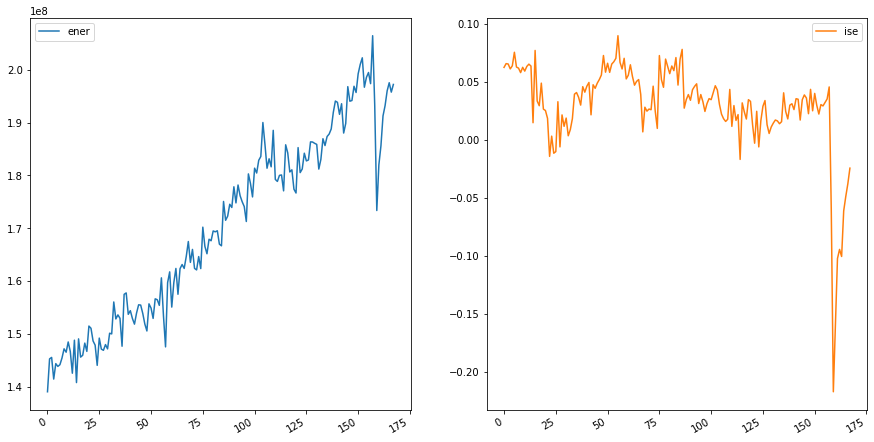

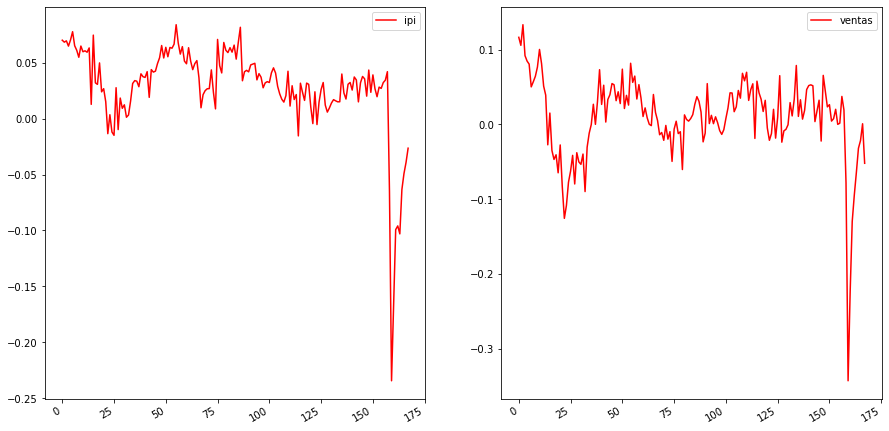

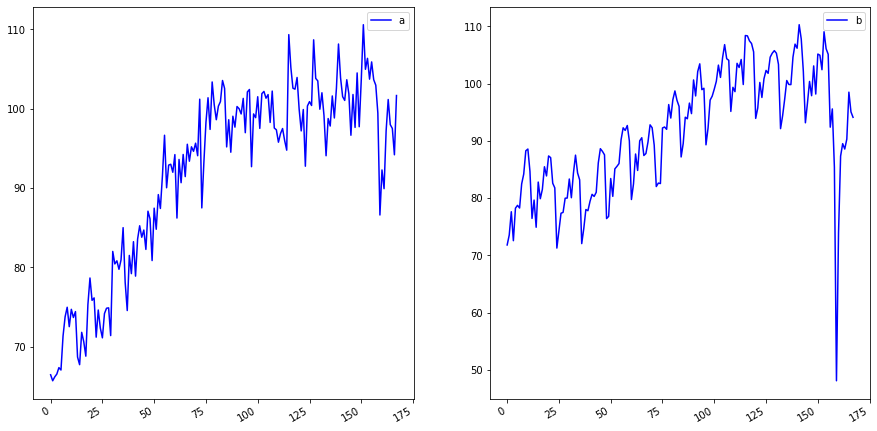

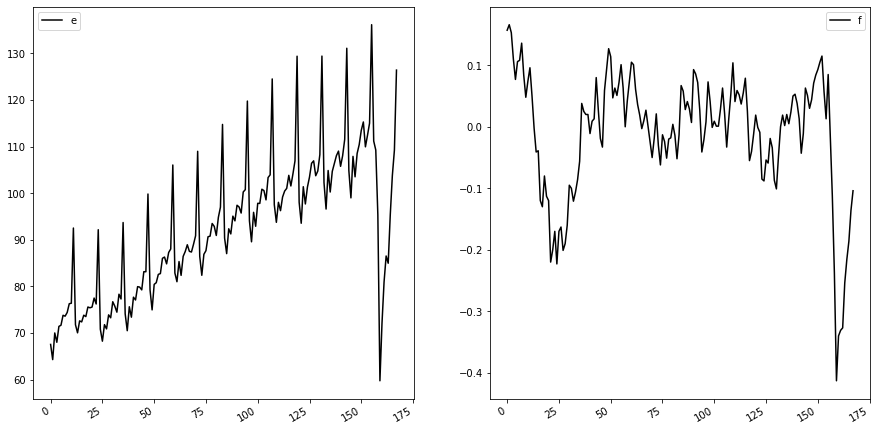

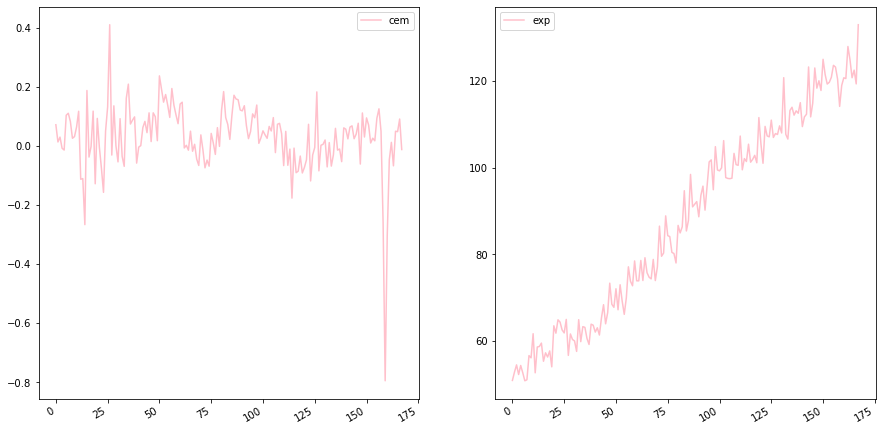

In [205]:
dta.loc[:, 'ener':'ise'].plot(subplots=True, layout=(1, 2), figsize=(15, 8));
dta.loc[:, 'ipi':'ventas'].plot(subplots=True, layout=(1, 2), figsize=(15, 8),color='red');
dta.loc[:, 'a':'b'].plot(subplots=True, layout=(1, 2), figsize=(15, 8),color='blue');
dta.loc[:, 'e':'f'].plot(subplots=True, layout=(1, 2), figsize=(15, 8),color='black');
dta.loc[:, 'cem':'exp'].plot(subplots=True, layout=(1, 2), figsize=(15, 8),color='pink');

Antes de ello es importante recordad que aunque existe datos para Colombia desde 1975 se usa desde el periodo 2005, puesto que, los ISE se tiene data desde esa fecha

Para el caso de Colombia y Antioquia:
El DANE ha sacado la siguientes series macro:
[PIB desde 1975](https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/agregados-macroeconomicos-retropolacion-base-2015)

Stock y Watson (1991) informan que para sus conjuntos de datos, no pudieron rechazar la hipótesis nula de una raíz unitaria en cada serie (por lo que las series están integradas), pero no encontraron evidencia sólida de que las series estuvieran cointegradas.

En consecuencia, sugieren estimar el modelo utilizando las primeras diferencias (de los logs) de las variables, degradadas y estandarizadas. Por consiguiente, en nuestro caso seguiremos el mismo procedimiento

# **Paso 4: Transformación de variables del Nowcast Antioquia (IMSEA)**

In [206]:
dta = pd.concat((xm, ise, ipi, ventas, emp, a, b, c, d, e, f, cem, exp, ventas2, emp2), axis=1)
dta.columns = ['ener', 'ise', 'ipi', 'ventas', 'emp','a','b','c','d','e','f','cem','exp', 'ventas2', 'emp2']

dta.tail()

,ener,ise,ipi,ventas,emp,a,b,c,d,e,f,cem,exp,ventas2,emp2
163,1.932255e+08,-0.100780,-0.103024,-0.064167,3397.900658,101.155431,88.573530,104.465811,2584.766760,84.989185,-0.254000,-0.067586,124.877344,-0.086891,-0.079166
164,1.960271e+08,-0.061529,-0.063351,-0.031906,3302.971663,97.984966,90.310747,109.190550,2544.873604,95.396997,-0.216000,0.049417,120.737844,-0.046609,-0.071625
165,1.975711e+08,-0.049135,-0.049138,-0.021513,3512.188908,97.510477,98.511374,118.145029,2644.953503,103.761597,-0.186003,0.048072,122.483699,-0.021985,-0.067709
166,1.957918e+08,-0.038137,-0.039135,0.000867,3969.999435,94.188346,95.065935,123.241210,2523.371875,109.274351,-0.136000,0.090815,119.312857,0.006668,-0.060719
167,1.972464e+08,-0.024656,-0.026422,-0.052000,3909.186572,101.659758,94.114033,128.292330,3028.972701,126.410117,-0.104000,-0.012460,132.962375,-0.054000,-0.080719


Stock y Watson (1991) sugieren estimar el modelo utilizando las primeras diferencias (de los logs) de las variables, degradadas y estandarizadas. Por consiguiente, en nuestro caso seguiremos el mismo procedimiento:

In [207]:
# Se estima el modelo utilizando las primeras diferencias (de los logs) de las variables
import numpy as np
# Creando las series de primeras diferencias (log-differenced)
dta['dln_ener'] = (np.log(dta.ener)).diff() * 100
dta['dln_ise'] = dta.ise
dta['dln_ipi'] = dta.ipi
dta['dln_ventas'] = dta.ventas
dta['dln_emp'] = (np.log(dta.emp)).diff() * 100
dta['dln_a'] = (np.log(dta.a)).diff() * 100
dta['dln_b'] = (np.log(dta.b)).diff() * 100
dta['dln_c'] = (np.log(dta.c)).diff() * 100
dta['dln_d'] = (np.log(dta.d)).diff() * 100
dta['dln_e'] = (np.log(dta.e)).diff() * 100
dta['dln_f'] = dta.f
dta['dln_cem'] = dta.cem
dta['dln_exp'] = (np.log(dta.exp)).diff() * 100
dta['dln_ventas2'] = dta.ventas2
dta['dln_emp2'] = dta.emp2
# Calcula la diferencia discreta de n-ésimo orden a lo largo del eje dado.

In [208]:
dta['std_ener'] = dta['dln_ener']
dta['std_ise'] =  dta['dln_ise']
dta['std_ipi'] = dta['dln_ipi']
dta['std_ventas'] = dta['dln_ventas']
dta['std_emp'] = dta['dln_emp']
dta['std_a'] = dta['dln_a']
dta['std_b'] = dta['dln_b'] 
dta['std_c'] = dta['dln_c'] 
dta['std_d'] = dta['dln_d'] 
dta['std_e'] = dta['dln_e']
dta['std_f'] = dta['dln_f']
dta['std_cem'] = dta['dln_cem'] 
dta['std_exp'] = dta['dln_exp']
dta['std_ventas2'] = dta['dln_ventas2']
dta['std_emp2'] = dta['dln_emp2']

In [167]:
# Se estima el modelo utilizando las primeras diferencias (de los logs) de las variables
import numpy as np
# Creando las series de primeras diferencias (log-differenced)
dta['dln_ener'] = (np.log(dta.ener)).diff() * 100
dta['dln_ise'] = dta.ise
dta['dln_ipi'] = dta.ipi
dta['dln_ventas'] = dta.ventas
dta['dln_emp'] = (np.log(dta.emp)).diff() * 100
dta['dln_a'] = (np.log(dta.a)).diff() * 100
dta['dln_b'] = (np.log(dta.b)).diff() * 100
dta['dln_c'] = (np.log(dta.c)).diff() * 100
dta['dln_d'] = (np.log(dta.d)).diff() * 100
dta['dln_e'] = (np.log(dta.e)).diff() * 100
dta['dln_f'] = dta.f
dta['dln_cem'] = dta.cem
dta['dln_exp'] = (np.log(dta.exp)).diff() * 100
dta['dln_ventas2'] = dta.ventas2
dta['dln_emp2'] = dta.emp2
# Calcula la diferencia discreta de n-ésimo orden a lo largo del eje dado.

# Media y estarandizando
dta['std_ener'] = (dta['dln_ener'] - dta['dln_ener'].mean()) / dta['dln_ener'].std()
dta['std_ise'] = (dta['dln_ise'] - dta['dln_ise'].mean()) / dta['dln_ise'].std()
dta['std_ipi'] = (dta['dln_ipi'] - dta['dln_ipi'].mean()) / dta['dln_ipi'].std()
dta['std_ventas'] = (dta['dln_ventas'] - dta['dln_ventas'].mean()) / dta['dln_ventas'].std()
dta['std_emp'] = (dta['dln_emp'] - dta['dln_emp'].mean()) / dta['dln_emp'].std()
dta['std_a'] = (dta['dln_a'] - dta['dln_a'].mean()) / dta['dln_a'].std()
dta['std_b'] = (dta['dln_b'] - dta['dln_b'].mean()) / dta['dln_b'].std()
dta['std_c'] = (dta['dln_c'] - dta['dln_c'].mean()) / dta['dln_c'].std()
dta['std_d'] = (dta['dln_d'] - dta['dln_d'].mean()) / dta['dln_d'].std()
dta['std_e'] = (dta['dln_e'] - dta['dln_e'].mean()) / dta['dln_e'].std()
dta['std_f'] = (dta['dln_f'] - dta['dln_f'].mean()) / dta['dln_f'].std()
dta['std_cem'] = (dta['dln_cem'] - dta['dln_cem'].mean()) / dta['dln_cem'].std()
dta['std_exp'] = (dta['dln_exp'] - dta['dln_exp'].mean()) / dta['dln_exp'].std()
dta['std_ventas2'] = (dta['dln_ventas2'] - dta['dln_ventas2'].mean()) / dta['dln_ventas2'].std()
dta['std_emp2'] = (dta['dln_emp2'] - dta['dln_emp2'].mean()) / dta['dln_emp2'].std()

# numpy.std: Calcule la desviación estándar de los datos dados (elementos de matriz) a lo largo del eje especificado (si corresponde)
# Una función cuadrada simple en python guardada como "sqd.py"

In [209]:
df = pd.concat((dta['std_ener'], dta['std_ise'], dta['std_ipi'], dta['std_ventas'], dta['std_emp'], dta['std_a'], dta['std_b'], dta['std_c'], dta['std_d'], dta['std_e'], dta['std_f'], dta['std_cem'], dta['std_exp'], dta['std_ventas2'], dta['std_emp2']), axis=1)
df.columns = ['ener', 'ise', 'ipi', 'ventas', 'emp','a','b','c','d','e','f','cem','exp','ventas2','emp2' ]

In [ ]:
df.to_excel("bntrans_excel.xlsx", index=False)

In [210]:
print(dta['std_ise'])

0      0.062180
1      0.065434
2      0.065109
3      0.060860
4      0.063561
         ...   
163   -0.100780
164   -0.061529
165   -0.049135
166   -0.038137
167   -0.024656
Name: std_ise, Length: 168, dtype: float64


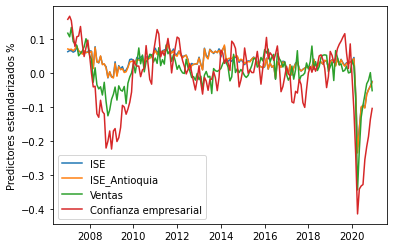

In [211]:
plt.plot(mes,dta['std_ise'])
plt.plot(mes,dta['std_ipi'])
plt.plot(mes,dta['std_ventas'])
plt.plot(mes,dta['std_f'])
plt.legend(['ISE','ISE_Antioquia','Ventas','Confianza empresarial'])
plt.ylabel('Predictores estandarizados %')
plt.show()

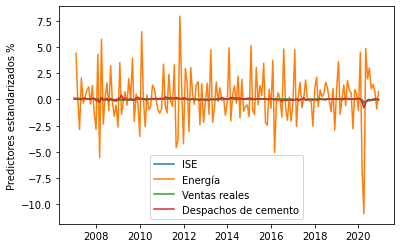

In [212]:
plt.plot(mes,dta['std_ise'])
plt.plot(mes,dta['std_ener'])
#plt.plot(mes,dta['std_ipi'])
plt.plot(mes,dta['std_ventas'])
plt.plot(mes,dta['std_cem'])
plt.legend(['ISE','Energía','Ventas reales','Despachos de cemento'])
plt.ylabel('Predictores estandarizados %')
plt.show()

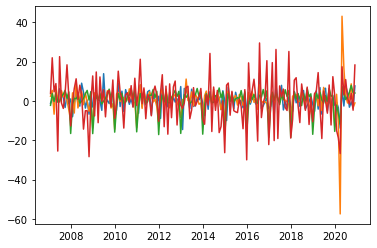

In [213]:
plt.plot(mes,dta['std_a'])
plt.plot(mes,dta['std_b'])
plt.plot(mes,dta['std_c'])
plt.plot(mes,dta['std_d'])
plt.show()

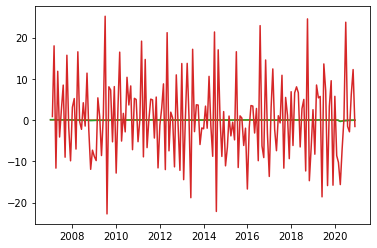

In [214]:
plt.plot(mes,dta['std_ise'])
plt.plot(mes,dta['std_ipi'])
plt.plot(mes,dta['std_ventas'])
plt.plot(mes,dta['std_emp'])
plt.show()

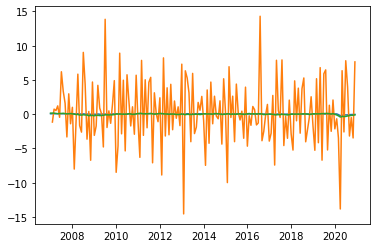

In [215]:
plt.plot(mes,dta['std_ise'])
plt.plot(mes,dta['std_a'])
plt.plot(mes,dta['std_f'])

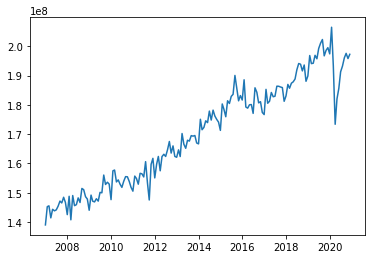

In [216]:
plt.plot(mes,xm)
plt.show()

# **Modelo Macro para Antioquia: Factores Dinámicos para la Industria**


---
Un modelo de factores dinámicos general se escribe como: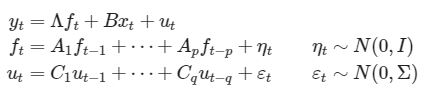


Donde yt son los datos observados, ft son los factores no observados (que evolucionan como un vector de autoregresivo), xt son las variables exógenas (opcionales), y ut es el proceso de error o "idiosincrásico" (también se permite opcionalmente que ut se autocorrelacione). La matriz Λ suele denominarse matriz de "cargas factoriales". La varianza del término de error factorial se fija en la matriz de identidad para asegurar la identificación de los factores no observados.

***Especificación del modelo***



---
El modelo de factor dinámico específico para la INDUSTRIA en Colombia tiene 1 factor no observado que se supone que sigue un proceso AR(2). Se supone que las innovaciones εt son independientes (de modo que Σ es una matriz diagonal) y el término de error asociado a cada ecuación, ui,t, se supone que sigue un proceso AR(2) independiente.


Por lo tanto, la especificación considerada aquí es:
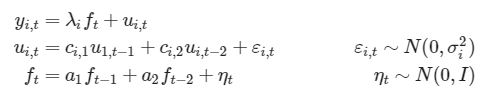

Siendo i: [indprod, income, sales, emp]

In [ ]:
print('Ver descripción de las variables en la primera parte o ver el excel')

Ver descripción de las variables en la primera parte o ver el excel


Siendo i es cada uno de: [indprod, income, sales, emp].

Este modelo puede ser formulado usando el modelo DynamicFactor incorporado a los modelos estadísticos (statsmodels). 
[Modelo DFM](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.dynamic_factor.DynamicFactor.html)

En particular, tenemos la siguiente especificación:

k_factores = 1 - (hay 1 factor no observado)

Factor_order = 2 - (sigue un proceso AR(2))

Error_var = Falso - (los errores evolucionan como procesos de AR independientes en lugar de conjuntamente como VAR - nótese que esta es la opción por defecto, por lo que no se especifica a continuación)

Error_order = 2 - (los errores se autocorrelacionan con el orden 2: es decir, los procesos AR(2))

error_cov_type = 'diagonal' - (las innovaciones no están correlacionadas; este es de nuevo el valor por defecto)

In [ ]:
# Si desean información adicional dirigirse a STATSMODELS

# **Estimación de parámetros**

---



Los modelos multivariantes pueden tener un número relativamente grande de parámetros, y puede ser difícil escapar de los mínimos locales para encontrar la máxima probabilidad. En un intento por mitigar este problema, realizo un paso inicial de maximización (a partir de los parámetros iniciales definidos por el modelo) utilizando el método Powell modificado disponible en Scipy (véase la documentación sobre minimización para obtener más información). Los parámetros resultantes se utilizan luego como parámetros de inicio en el método de optimización estándar del LBFGS

# **Paso 5: Programación IMSEA del modelo Nowcasting usando los factores dinámicos**

In [217]:
# Obteniendo los datos endógenos, son los datos observados estandarizados
endog = dta.loc['2005-01-01':, 'std_ener':'std_exp']

# Por fin creando el modelo
# statsmodels.tsacontiene clases de modelo y funciones que son útiles para el análisis de series de tiempo
nowcast = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
# engog: El proceso de series de tiempo observado.
# k_factors: El número de factores no observados.
# factor_order: El orden de la autorregresión del vector seguido de los factores.
# error_order: El orden de la autorregresión del vector seguido del componente del error de observación
#initial_res = nowcast.fit(method='powell', disp=False)
initial_res = nowcast.fit(method='powell')
res = nowcast.fit(initial_res.params, disp=False)

Optimization terminated successfully.
         Current function value: 14.819976
         Iterations: 11
         Function evaluations: 7413


C:\Users\DIEGO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4465.072996084758


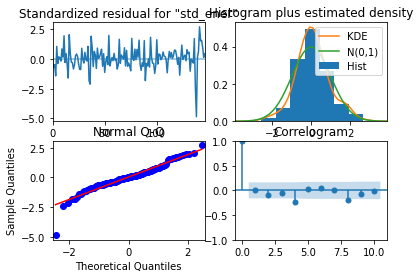

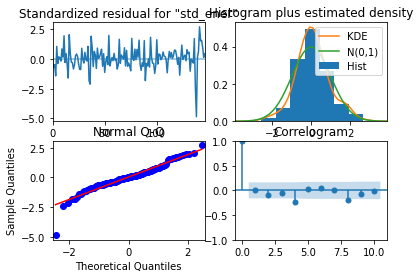

In [218]:
dates = endog.index._mpl_repr()
print(res.aic)
res.plot_diagnostics()

# **Estimación**

---



Una vez que el modelo ha sido estimado, hay dos componentes que podemos utilizar para el análisis o la inferencia:

1) Los parámetros estimados

2) El factor estimado

# **Parámetros**

Los parámetros estimados pueden ser útiles para comprender las implicaciones del modelo, aunque en los modelos con un mayor número de variables observadas y/o factores no observados pueden ser difíciles de interpretar.

Una de las razones de esta dificultad se debe a problemas de identificación entre las cargas de factores y los factores no observados. Una cuestión de identificación fácil de ver es el signo de las cargas y los factores: un modelo equivalente al que se muestra a continuación resultaría de la inversión de los signos de todas las cargas de los factores y el factor no observado.

Aquí, una de las implicaciones fáciles de interpretar en este modelo es la persistencia del factor no observado: encontramos que exhibe una persistencia sustancial.

In [220]:
print(res.coefficients_of_determination)
# ['ener', 'ise', 'ipi', 'ventas', 'emp','a','b','c','d','e','f','cem','exp','ventas2','emp2' ]

[[0.0288]
 [0.9943]
 [0.9998]
 [0.5849]
 [0.0217]
 [0.0187]
 [0.0266]
 [0.0007]
 [0.0119]
 [0.0118]
 [0.6098]
 [0.4519]
 [0.0001]]


In [221]:
# Impriendo las principales medidas estadísticas
# Para nuestro Nowcast Antioquia de la actividad económica

print(res.summary(separate_params=False))

                                                                                      Statespace Model Results                                                                                     
Dep. Variable:     ['std_ener', 'std_ise', 'std_ipi', 'std_ventas', 'std_emp', 'std_a', 'std_b', 'std_c', 'std_d', 'std_e', 'std_f', 'std_cem', 'std_exp']   No. Observations:                  147
Model:                                                                                                                   DynamicFactor(factors=1, order=2)   Log Likelihood               -2178.536
                                                                                                                                            + AR(2) errors   AIC                           4465.073
Date:                                                                                                                                     Tue, 09 Mar 2021   BIC                           4626.556
Time:               

<ipython-input-222-04d37a87a0c4>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([ 0.0925, -0.0824,  0.0194, -0.0726, -0.0871,  0.1717, -0.0615,  0.1076,  0.0556,  0.08  ,  0.0104,  0.0168,
        0.0917,  0.1934,  0.2127,  0.2041,  0.1674,  0.2413,  0.2332,  0.2302,  0.2542,  0.1086,  0.2641,  0.2589,
        0.2641,  0.297 ,  0.3239,  0.3976,  0.3372,  0.3912,  0.3312,  0.3813,  0.3858,  0.4123,  0.5123,  0.4048,
        0.3463,  0.3967,  0.3198,  0.2972,  0.3783,  0.3106,  0.2726,  0.304 ,  0.3122,  0.217 ,  0.0588,  0.1373,
        0.1557,  0.1571,  0.1572,  0.2676,  0.1502,  0.0541,  0.4242,  0.2848,  0.2534,  0.42  ,  0.3698,  0.3524,
        0.3847,  0.3678,  0.4048,  0.3195,  0.4076,  0.4977,  0.2125,  0.257 ,  0.2574,  0.2497,  0.2951,  0.303 ,
        0.3015,  0.2048,  0.2412,  0.2293,  0.173 ,  0.1932,  0.1957,  0.1953,  0.2537,  0.2796,  0.2456,  0.1711,
        0.1349,  0.1103,  0.0921,  0.1215,  0.254 ,  0.0703,  0.1835,  0.1042,  0.1267, -0.0965,  0.1958,  0.148 ,
        0.0983,  0.1889,  0.1854,  0.0674, -0.024 ,  0.1437, -0.0364,  0.0906,  

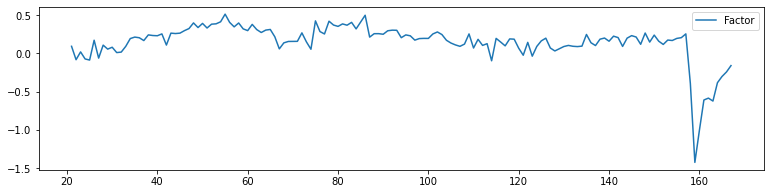

In [222]:
# Graficando los resultados

fig, ax = plt.subplots(figsize=(13,3))

# Graficando el factor
dates = endog.index._mpl_repr()
# La función repr () devuelve una representación imprimible del objeto dado
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()
fig.show()
res.factors.filtered[0]


# **Factores estimados**

---



Un poquito más de teoría
Factores estimados
Si bien puede ser útil para trazar los factores no observados, es menos útil aquí de lo que se podría pensar por dos razones:

1) El problema de identificación relacionado con los signos descrito anteriormente.

2) Como los datos eran diferentes, el factor estimado explica la variación de los datos diferenciados, no los datos originales.

Por estas razones se crea el índice de coincidencia (véase más adelante).

Con estas reservas, el factor no observado se grafica a continuación, junto con los indicadores del NBER para las recesiones de EE.UU. Parece que el factor tiene éxito al recoger algún grado de actividad del ciclo económico.

# **Post-estimación**

---


Aunque aquí podremos interpretar los resultados del modelo construyendo el índice de coincidencia, existe un enfoque útil y genérico para obtener una idea de lo que está siendo capturado por el factor estimado. Tomando los factores estimados como dados, regresándolos (y una constante) cada uno (uno a la vez) en cada una de las variables observadas, y registrando los coeficientes de determinación (valores R2), podemos obtener una sensación de las variables para las cuales cada factor explica una porción sustancial de la varianza y las variables para las cuales no lo hace.

En los modelos con más variables y más factores, esto puede a veces dar interpretación a los factores (por ejemplo, a veces un factor se cargará principalmente en las variables reales y otro en las variables nominales).

En este modelo, con sólo cuatro variables endógenas y un factor, es fácil digerir un simple cuadro de los valores de R2, pero en modelos más grandes no lo es. Por esta razón, se suele emplear un gráfico de barras; a partir del gráfico podemos ver fácilmente que el factor explica la mayor parte de la variación del índice de producción industrial y una gran parte de la variación de las ventas y el empleo, es menos útil para explicar los ingresos.

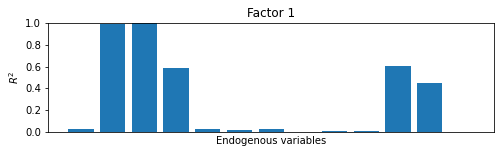

In [224]:
# Nivel de importancia de la variable Nowcast Industria colombiana

#   ['ener', 'ise', 'ipi', 'ventas', 'emp','a','b','c','d','e','f','cem','exp','ventas2','emp2' ]

res.plot_coefficients_of_determination(figsize=(8,2));

Cómo se puede notar la variabla más importante y predictora del nowcast industria para Colombia es el ISE para la industria, seguida por el índice de producción real y ventas reales y en menor medida el empleo permanente total de la industria

# **IMSEA**

---


Como se ha descrito anteriormente, el objetivo de este modelo era crear una serie interpretable que pudiera utilizarse para comprender el estado actual de la macroeconomía. Esto es lo que el índice de coincidencia está diseñado para hacer. Se construye a continuación. De forma más amplia la construcción se puede ver Kim y Nelson (1999) o Stock y Watson (1991), (2002). Banbura et al (2013).

Escrito en forma de espacio de estado, la especificación anterior del modelo tenía la siguiente ecuación de observación (Design: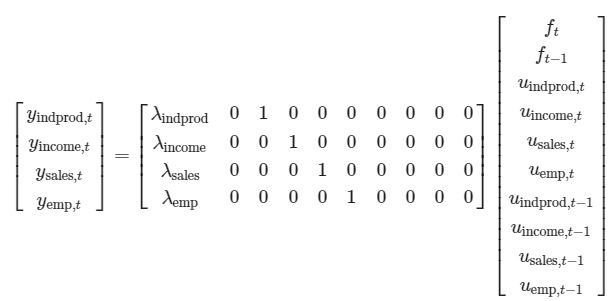

el DynamicFactormodelo maneja la configuración de la representación del espacio de estado y, en el DynamicFactor.updatemétodo, completa los valores de los parámetros ajustados en las ubicaciones apropiadas.
La ecuación de transición: 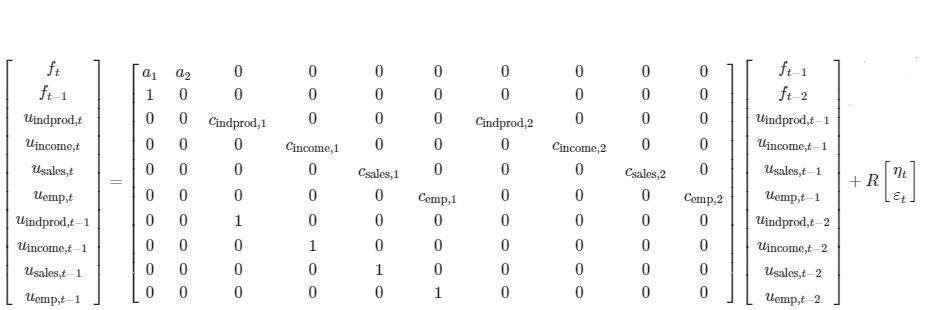

In [225]:
# Transformamos el índice sacando la primera diferencia
# SSM. El módulo admite la obtención de un solo parámetro, múltiples 
# parámetros o todos los parámetros que coinciden con una ruta en particular.
# Ganancia de Kalman que se usó en la llamada update () más reciente. Shape:forma
# Calcule la inversa (multiplicativa) de una matriz. linalg.inv
# np.eye :Devuelve una matriz 2-D con unos en la diagonal y ceros en el resto.

#dusphci = usphci.diff()[1:].values
def compute_coincident_index(nowcast, res):
    # Estimando W(1)
    spec = res.specification
    design = nowcast.ssm['design']
    transition = nowcast.ssm['transition']
    ss_kalman_gain = res.filter_results.kalman_gain[:,:,-1]
    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(np.eye(k_states) - np.dot(
        np.eye(k_states) - np.dot(ss_kalman_gain, design),
        transition
    )).dot(ss_kalman_gain)[0]

    # Calculando el vector medio del factor
    # Producto escalar de dos matrices np.dot
    factor_mean = np.dot(W1, dta.loc['2005-01-01':, 'dln_ener':'dln_a'].mean())

    # Normalizando los factores
    factor = res.factors.filtered[0]
    #factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Calculando el índice coincidente
    coincident_index = np.zeros(nowcast.nobs+1)
    # El valor inicial es arbitrario; aquí se establece como
    # facilitar la comparación
    #coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    #for t in range(0, nowcast.nobs):
    #    coincident_index[t+1] = coincident_index[t] + factor[t] + factor_mean

    # Adjuntando las fechas de tiempo
    #coincident_index = pd.Series(coincident_index, index=dta.index).iloc[1:]

    # Normalizar para usar el mismo año base que el USPHCI
    #coincident_index *= (usphci.loc['1992-07-01'] / coincident_index.loc['1992-07-01'])

    return coincident_index

A continuación se gráfica el índice de coincidencia calculado para la industria en la economía antioqueña

<ipython-input-226-787b9c541e3d>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


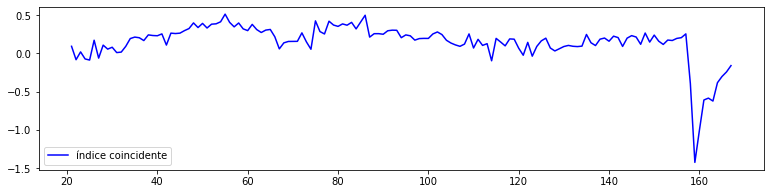

In [226]:
# Graficando los índices encontrados
fig, ax = plt.subplots(figsize=(13,3))

# Calculando el índice
#coincident_index = compute_coincident_index(nowcast, res)

# Graficando el factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='índice coincidente', color="blue")
# Ubicación de la leyenda
ax.legend(loc='lower left')
fig.show()

In [192]:
print(res.factors.filtered[0])

[ -0.555   -1.8371  -1.1146  -1.7882  -1.8916  -0.0125  -1.6414  -0.4097  -0.809   -0.6496  -1.1366  -1.0374  -0.4964
   0.2165   0.3469   0.318    0.0888   0.6082   0.4962   0.4985   0.7354  -0.2824   0.7939   0.6922   0.7423   1.0277
   1.2392   1.7356   1.2477   1.6532   1.28     1.6319   1.6073   1.7654   2.5347   1.7984   1.3628   1.669    1.09
   1.0005   1.6104   1.0874   0.7524   0.9717   1.0769   0.4159  -0.7927  -0.2582  -0.1199  -0.0627  -0.0702   0.6651
  -0.2133  -0.8624   1.8455   0.8446   0.5698   1.7521   1.4498   1.3431   1.5342   1.3573   1.6554   1.0679   1.7242
   2.2979   0.1822   0.503    0.548    0.4619   0.7236   0.7577   0.7954   0.1424   0.3911   0.2431  -0.1709   0.0317
   0.1049   0.092    0.4709   0.6796   0.4977  -0.0096  -0.3027  -0.5055  -0.61    -0.3736   0.5861  -0.7671   0.0246
  -0.5152  -0.3193  -1.9425   0.1142  -0.2318  -0.5458   0.1401   0.1009  -0.7743  -1.4253  -0.19    -1.477   -0.5947
  -0.0922   0.1804  -0.7031  -0.9865  -0.8206  -0.6323  -0

# **Extendiendo el modelo de factor dinámico para Antioquia**

Recordemos que la especificación anterior fue descrita por: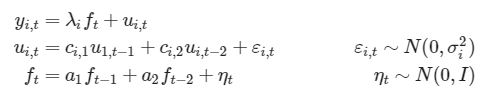

Escrito en forma de espacio de estado, la especificación anterior del modelo tenía la siguiente ecuación de observación: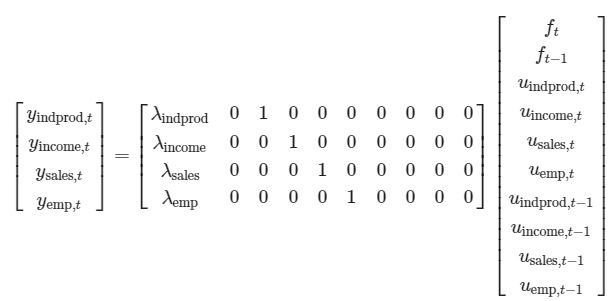

El modelo DynamicFactor se encarga de configurar la representación del espacio de estado y, en el método DynamicFactor.update, rellena los valores de los parámetros ajustados en los lugares apropiados.

La especificación ampliada es la misma que en el ejemplo anterior, excepto que también queremos permitir que el empleo dependa de los valores retardados del factor. Esto crea un cambio en la ecuación yemp,t. Ahora lo tenemos: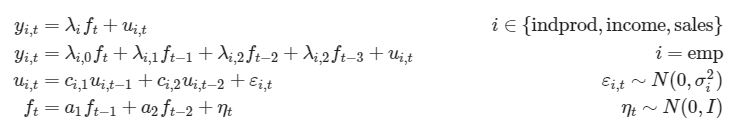

Ahora, la ecuación de observación correspondiente debería verse así: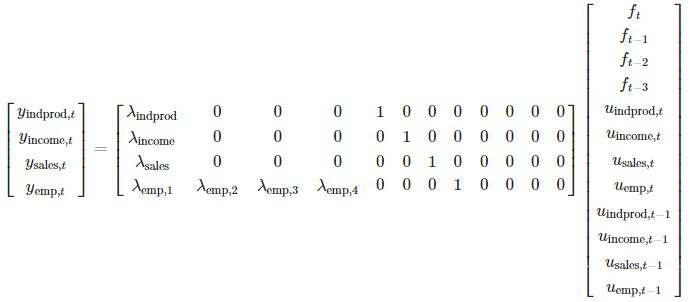

Observe que hemos introducido dos nuevas variables de estado, ft−2 y ft−3, lo que significa que debemos actualizar la ecuación de transición: 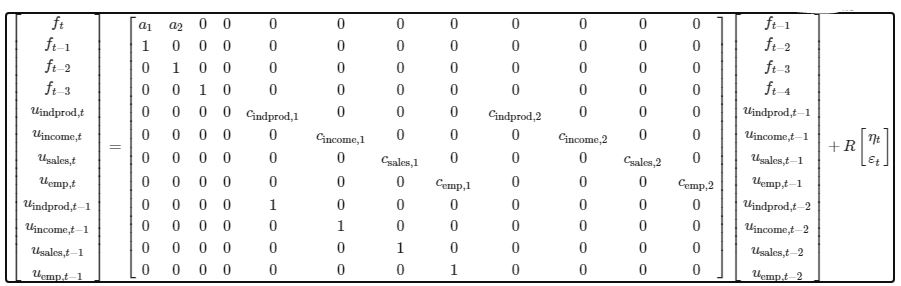

La DynamicFactorclase no puede manejar este modelo de forma inmediata , pero se puede manejar creando una subclase cuando se altera la representación del espacio de estado de la manera apropiada.

Nuestra estrategia será crear una subclase DynamicFactory dejar que haga la mayor parte del trabajo (configurar la representación del espacio de estado, etc.) donde asume eso . Lo único que realmente haremos en la subclase será solucionar esos dos problemas.factor_order = 4

Primero, aquí está el código completo de la subclase; se analiza a continuación. Es importante señalar desde el principio que ninguno de los métodos definidos a continuación podría haberse omitido. De hecho, los métodos __init__, start_params, param_names, transform_params, untransform_params, y updateforman el núcleo de todos los modelos de espacio de estado en statsmodels, no sólo la DynamicFactorclase.

# **Descripción del código**

---

`` __init__``

El paso importante aquí es especificar el modelo de factor dinámico base con el que estábamos operando. En particular, como se describió anteriormente, inicializamos con factor_order=4, aunque solo terminaremos con un modelo AR (2) para el factor. También realizamos algunas tareas generales relacionadas con la configuración.

`` start_params``

start_paramsse utilizan como valores iniciales en el optimizador. Ya que estamos agregando tres nuevos parámetros, necesitamos pasarlos. Si no hubiéramos hecho esto, el optimizador usaría los valores iniciales predeterminados, que serían tres elementos menos.

`` nombres_param ''

param_namesse utilizan en una variedad de lugares, pero especialmente en la clase de resultados. A continuación, obtenemos un resumen de resultados completo, que solo es posible cuando todos los parámetros tienen nombres asociados.

`` transform_params '' y `` untransform_params ''

El optimizador selecciona los posibles valores de los parámetros sin restricciones. Por lo general, no se desea (dado que las variaciones no pueden ser negativas, por ejemplo) y transform_paramsse usa para transformar los valores no restringidos que usa el optimizador en valores restringidos apropiados para el modelo. Los términos de las varianzas son típicamente al cuadrado (para forzarlos a ser positivos), y los coeficientes de retardo AR a menudo están restringidos para conducir a un modelo estacionario. untransform_paramsse usa para la operación inversa (y es importante porque los parámetros de inicio generalmente se especifican en términos de valores apropiados para el modelo, y necesitamos convertirlos en parámetros apropiados para el optimizador antes de que podamos comenzar la rutina de optimización).




In [227]:
# Subclase del Dinámico de Factores Dinámicos

from statsmodels.tsa.statespace import tools
class ExtendedDFM(sm.tsa.DynamicFactor):
    def __init__(self, endog, **kwargs):
            # Configurar el modelo como si tuviéramos un factor de orden 4
            super(ExtendedDFM, self).__init__(
                endog, k_factors=1, factor_order=2, error_order=2,
                **kwargs)

            # Nota: ``self.parameters`` es un dictado ordenado con el
            # que corresponden a los tipos de parámetros, y los valores
            # el número de parámetros de ese tipo.
            # Añadiendo los nuevos parámetros
            self.parameters['new_loadings'] = 3

            # Cache a una rebanada para la ubicación del factor 4 AR
            # parámetros (a_1, ..., a_4) en el vector de parámetros completo
            offset = (self.parameters['factor_loadings'] +
                      self.parameters['exog'] +
                      self.parameters['error_cov'])
            self._params_factor_ar = np.s_[offset:offset+2]
            self._params_factor_zero = np.s_[offset+2:offset+4]

    @property
    def start_params(self):
        # Añade tres nuevos parámetros de carga al final del parámetro
        # vector, inicializado a ceros (por simplicidad; 
        # pueden ser inicializados de cualquier manera)
        return np.r_[super(ExtendedDFM, self).start_params, 0, 0, 0]

    @property
    def param_names(self):
        # Añade los nombres correspondientes a los nuevos parámetros de carga
        #  (Pueden agregar el nombre que deseen como antes de los iguales)
        return super(ExtendedDFM, self).param_names + [
            'loading.L%d.f1.%s' % (i, self.endog_names[3]) for i in range(1,4)]

    def transform_params(self, unconstrained):
            # Realizar la típica transformación DFM (sin los nuevos parámetros)
            constrained = super(ExtendedDFM, self).transform_params(
            unconstrained[:-3])

            # Rehaciendo la restricción del factor AR, ya que sólo queremos un AR(2),
            # y la restricción anterior era para un AR(4)
            ar_params = unconstrained[self._params_factor_ar]
            constrained[self._params_factor_ar] = (
                tools.constrain_stationary_univariate(ar_params))

            # Devuelve todos los parámetros
            return np.r_[constrained, unconstrained[-3:]]

    def untransform_params(self, constrained):
            # Realizar la típica destransformación DFM (sin los nuevos parámetros)
            unconstrained = super(ExtendedDFM, self).untransform_params(
                constrained[:-3])

            # Rehacer el factor AR sin restricciones, ya que sólo queremos un AR(2),
            # y el anterior sin restricciones era para un AR(4)
            ar_params = constrained[self._params_factor_ar]
            unconstrained[self._params_factor_ar] = (
                tools.unconstrain_stationary_univariate(ar_params))

            # Retornar todos los parámetros
            return np.r_[unconstrained, constrained[-3:]]

    def update(self, params, transformed=True, **kwargs):
        # Realizar la transformación, si es necesario
        if not transformed:
            params = self.transform_params(params)
        params[self._params_factor_zero] = 0

        # Ahora realice la habitual actualización del DFM, pero excluya nuestros nuevos parámetros
        super(ExtendedDFM, self).update(params[:-3], transformed=True, **kwargs)

        # Por último, establecer nuestros nuevos parámetros en la matriz de diseño
        self.ssm['design', 3, 1:4] = params[-3:]

Aunque no necesitamos transformar o deshacer la transformación de nuestros nuevos parámetros (las cargas pueden, en teoría, tomar cualquier valor), aún necesitamos modificar esta función por dos razones:

1) La versión de la DynamicFactorclase espera 3 parámetros menos de los que tenemos ahora. Como mínimo, necesitamos manejar los tres nuevos parámetros.

2) La versión en la DynamicFactorclase restringe los coeficientes de retardo de los factores a ser estacionarios como si fuera un modelo AR (4). Dado que en realidad tenemos un modelo AR (2), necesitamos volver a hacer la restricción. También establecemos los dos últimos coeficientes autorregresivos en cero aquí.

La razón más importante por la que necesitamos especificar un nuevo método de actualización es porque tenemos tres nuevos parámetros que necesitamos colocar en la formulación del espacio de estado. En particular, dejamos que la clase padre DynamicFactor.update se encargue de colocar todos los parámetros excepto los tres nuevos en la representación del espacio de estado, y luego ponemos los tres últimos manualmente.

In [228]:
# Creando el modelo
extended_mod = ExtendedDFM(endog)
initial_extended_res = extended_mod.fit(maxiter=2000, disp=False)
extended_res = extended_mod.fit(initial_extended_res.params, method='nm', maxiter=1000)
print(extended_res.summary(separate_params=False))

C:\Users\DIEGO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\DIEGO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                      Statespace Model Results                                                                                     
Dep. Variable:     ['std_ener', 'std_ise', 'std_ipi', 'std_ventas', 'std_emp', 'std_a', 'std_b', 'std_c', 'std_d', 'std_e', 'std_f', 'std_cem', 'std_exp']   No. Observations:                  147
Model:                                                                                                                   DynamicFactor(factors=1, order=2)   Log Likelihood               -2441.665
                                                                                                                                            + AR(2) errors   AIC                           4997.329
Date:                                                                                                                                     Tue, 09 Mar 2021   BIC                           5167.784
Time:               

Aunque este modelo aumenta la probabilidad, no es el preferido por las medidas AIC y BIC que penalizan los tres parámetros adicionales.

Además, los resultados cualitativos no han cambiado, como se puede ver en el gráfico actualizado de R2 y el nuevo índice de coincidencia, ambos prácticamente idénticos a los resultados anteriores.

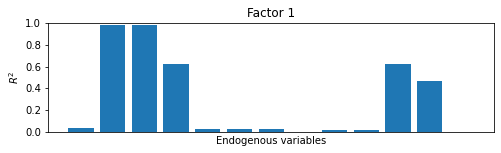

In [229]:
# Importancia de variable en el modelo extendido
#dta.columns = ['ener', 'ise', 'ipi', 'ventas', 'emp','a']
extended_res.plot_coefficients_of_determination(figsize=(8,2));

<ipython-input-230-d3e83941d315>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([ 0.0925, -0.0824,  0.0194, -0.0726, -0.0871,  0.1717, -0.0615,  0.1076,  0.0556,  0.08  ,  0.0104,  0.0168,
        0.0917,  0.1934,  0.2127,  0.2041,  0.1674,  0.2413,  0.2332,  0.2302,  0.2542,  0.1086,  0.2641,  0.2589,
        0.2641,  0.297 ,  0.3239,  0.3976,  0.3372,  0.3912,  0.3312,  0.3813,  0.3858,  0.4123,  0.5123,  0.4048,
        0.3463,  0.3967,  0.3198,  0.2972,  0.3783,  0.3106,  0.2726,  0.304 ,  0.3122,  0.217 ,  0.0588,  0.1373,
        0.1557,  0.1571,  0.1572,  0.2676,  0.1502,  0.0541,  0.4242,  0.2848,  0.2534,  0.42  ,  0.3698,  0.3524,
        0.3847,  0.3678,  0.4048,  0.3195,  0.4076,  0.4977,  0.2125,  0.257 ,  0.2574,  0.2497,  0.2951,  0.303 ,
        0.3015,  0.2048,  0.2412,  0.2293,  0.173 ,  0.1932,  0.1957,  0.1953,  0.2537,  0.2796,  0.2456,  0.1711,
        0.1349,  0.1103,  0.0921,  0.1215,  0.254 ,  0.0703,  0.1835,  0.1042,  0.1267, -0.0965,  0.1958,  0.148 ,
        0.0983,  0.1889,  0.1854,  0.0674, -0.024 ,  0.1437, -0.0364,  0.0906,  

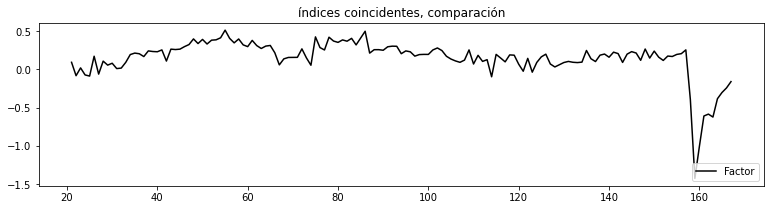

In [230]:
fig, ax = plt.subplots(figsize=(13,3))

# Cálculo del índice
#extended_coincident_index = compute_coincident_index(extended_mod, extended_res)

# Gráficando el factor
dates = endog.index._mpl_repr()
#ax.plot(dates, coincident_index, '-', linewidth=1, label='Modelo básico NowCast', color="blue")
ax.plot(dates, res.factors.filtered[0], label='Factor',color='black')
#ax.plot(dates, res.factors.filtered[1], '--', linewidth=3, label='Modelo NowCast extendido', color="green")
#ax.plot(usphci.index._mpl_repr(), usphci, label='índice FED F', color="red")
ax.legend(loc='lower right')
ax.set(title='índices coincidentes, comparación')
fig.show()

res.factors.filtered[0]

In [231]:
point_forecasts = res.forecast(steps=4)
print(point_forecasts.T.head())
predicted_result = res.predict(start=168, end=171)

                 168       169       170       171
std_ener   -0.199958 -0.358514  0.061095 -0.001674
std_ise    -0.018893 -0.014091 -0.010625 -0.007922
std_ipi    -0.020865 -0.015378 -0.010785 -0.008142
std_ventas -0.009733 -0.022045 -0.008661 -0.010172
std_emp    -2.683194  1.142427 -0.356893 -0.378500


                 168       169       170
std_ener   -0.093604 -0.180563 -0.016372
std_ise    -1.117081 -0.902998 -0.732017
std_ipi    -1.108218 -0.896826 -0.725393
std_ventas -0.375325 -0.520229 -0.290824
std_emp    -0.385560  0.063220 -0.083345


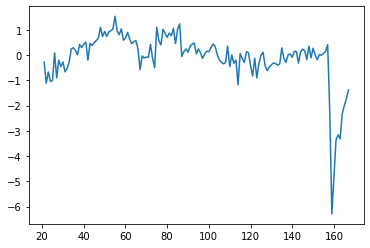

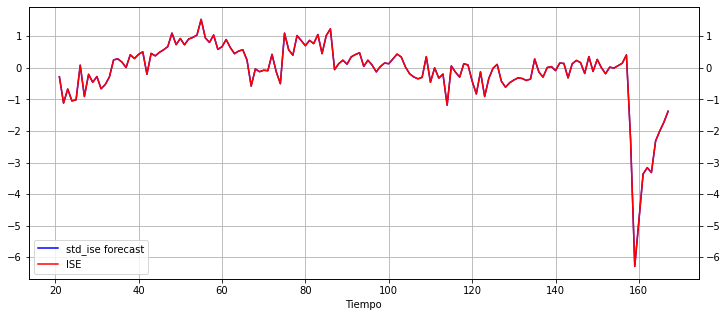

In [199]:
point_forecasts = res.forecast(steps=3)
print(point_forecasts.T.head())
predicted_result = res.predict(start=168, end=170)
f_ise = endog['std_ise'].append(predicted_result['std_ise'])
date_rng = pd.date_range(start='1/2007', end='5/2021', freq='M')
df = pd.DataFrame(date_rng , columns=['fecha'])
df['std_ise'] = endog['std_ise']
df['std_ise_f'] = f_ise
df['std_ise_f'].plot()
df.to_excel('industria.xlsx', index = False)

plt.figure(figsize=(12,5))
plt.xlabel('Tiempo')

ax1 = df['std_ise_f'].plot(color='blue', grid=True, label='std_ise forecast')
ax2 = df['std_ise'].plot(color='red', grid=True, secondary_y=True, label='ISE')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=3)
#plt.show()

Optimization terminated successfully.
         Current function value: 3.117336
         Iterations: 9
         Function evaluations: 3339
945.3193016048724
               142        143        144        145        146
emp      -0.065512  -0.058338  -0.052823  -0.048076  -0.043837
ise      -0.030143  -0.024439  -0.021366  -0.018852  -0.016630
tgpcol   62.462051  62.847996  62.940296  63.098313  63.195139
tgpamva  63.740411  63.868369  63.925348  63.961673  63.989989
cem       0.017460  -0.003138  -0.016961  -0.023200  -0.025632


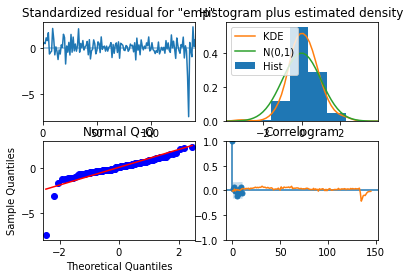

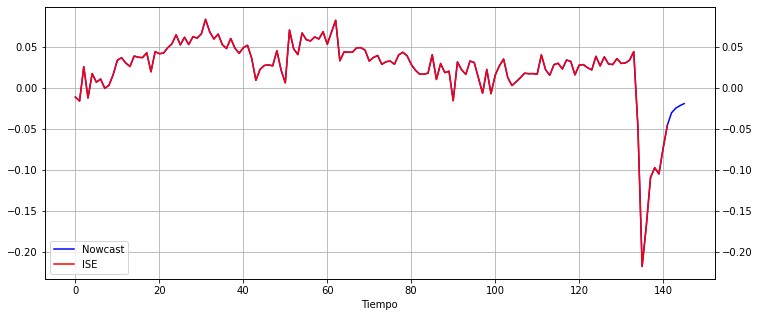

<Figure size 432x288 with 0 Axes>

In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
np.set_printoptions(precision=4, suppress=True, linewidth=120)
start = '2009-01-01'   # Periodo mensual de inicio
end = '2020-08-01'     # Periodo mensual final
datos=pd.read_excel('DataNowcastingv3.xlsx')
emp = datos['cre_emp_ant']                             # ISE Nacional
export = datos['crec_export']                             # Índice de Producción Real
exportng = datos['crec_export_noagro']                      # Ventas reales industriales
ise = datos['ise_ant']                          # Empleados de la industria
tgpcol = datos['tgp_col']                    # Expectativa de venta de los últimos 12 meses por parte de industriales
tgpamva = datos['tgp_amva']                 # Expectativa de venta de los próximo 12 meses por parte de industriales
googlet = datos['gt']                     # Expectativa de inversión en maquinaria por parte de industriales
cem = datos['cem']    
conf_cons = datos['conf_cons']    
dta = pd.concat((emp, ise, tgpcol, tgpamva, cem, conf_cons, googlet, 
                 export, exportng, ), axis=1)
dta.columns = ['emp', 'ise', 'tgpcol','tgpamva', 'cem', 'conf_cons', 'googlet', 'export', 'exportnp', ]
dta.tail()  # Mostrando los últimos cinco datos de todas las variables.
dta.describe()  # Mostrando las principales estadísticas de cada una de las variables
#dta.loc[:, 'emp':'ise'].plot(subplots=True, layout=(1, 2), figsize=(15, 8));
#dta.loc[:, 'cem':'conf_cons'].plot(subplots=True, layout=(1, 2), figsize=(15, 8),color='red');
dta['std_emp'] = (dta['emp'] - dta['emp'].mean()) / dta['emp'].std()
dta['std_exp'] = (dta['export'] - dta['export'].mean()) / dta['export'].std()
dta['std_expng'] = (dta['exportnp'] - dta['exportnp'].mean()) / dta['exportnp'].std()
dta['std_ise'] = (dta['ise'] - dta['ise'].mean()) / dta['ise'].std()
dta['std_tgpcol'] = (dta['tgpcol'] - dta['tgpcol'].mean()) / dta['tgpcol'].std()
dta['std_tgpamva'] = (dta['tgpamva'] - dta['tgpamva'].mean()) / dta['tgpamva'].std()
dta['std_googlet'] = (dta['googlet'] - dta['googlet'].mean()) / dta['googlet'].std()
df = pd.concat((dta['std_emp'], dta['std_exp'], dta['std_expng'], dta['std_ise'], dta['std_tgpcol'], dta['std_tgpamva'], 
                dta['std_googlet']), axis=1)
df.columns = ['emp', 'export', 'exportnp', 'ise', 'tgpcol','tgpamva','googlet']
df.to_excel("stdnowcast.xlsx", index=False)
#print(dta['std_ise'])
endog = dta.loc[:, 'emp':'googlet']
nowcast = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = nowcast.fit(method='powell')
res = nowcast.fit(initial_res.params, disp=False)
res.summary()
#print(res.summary(separate_params=False))
dates = endog.index._mpl_repr()
print(res.aic)
res.plot_diagnostics()

#fig, ax = plt.subplots(figsize=(6,3))
#ax.plot(dates, res.factors.filtered[0], label='Factor')

#res.plot_coefficients_of_determination(figsize=(8,2));

# Forecast
point_forecasts = res.forecast(steps=5)
print(point_forecasts.T.head())

predicted_result = res.predict(start=142, end=145)

f_emp = endog['ise'].append(predicted_result['ise'])

date_rng = pd.date_range(start='1/2009', end='03/2021', freq='M')
df = pd.DataFrame(date_rng , columns=['fecha'])
df['ise'] = endog['ise']
df['ise_f'] = f_emp
df['ise_f'].plot()

plt.figure(figsize=(12,5))
plt.xlabel('Tiempo')

ax1 = df['ise_f'].plot(color='blue', grid=True, label='Nowcast')
ax2 = df['ise'].plot(color='red', grid=True, secondary_y=True, label='ISE')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=3)
plt.show()
plt.savefig("dfmodel.png")  

In [33]:
import pandas as pd
datos=pd.read_excel('industria.xlsx','vbdfm')

## Se utilizan las variables de mayores correlaciones dinámicas
pib = datos['PIB_Antioquia']
ise = datos['ISE']     # Producción industrial
ipi = datos['Produción Industrial']   # Ingresos totales reales
vent = datos['Ventas reales']   # Ventas reales industriales y comerciales
cement = datos['cemento_Antioquia']       # Empleados de la industria
exp = datos['Exportaciones_Antioquia']    # Expectativa de venta de los últimos 12 meses por parte de industriales
#lic = datos['licencias']        # Consumo de energía
imp = datos['Importaciones_Antioquia'] 
des = datos['Desocupados_AMVA']
tri = datos['Mes']

<AxesSubplot:>

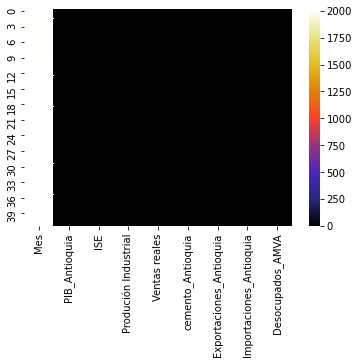

In [34]:
import seaborn as sns
sns.heatmap(datos, cmap='CMRmap',cbar=True,linewidths=.00001,xticklabels='auto')
#plt.ylabel('Crecimiento trimestral %')
#plt.legend(['NowCast Industria'])

El error es:  0.015078869780304085
The value of r2 is:  0.8258087256470479
The parameters are: 
' [0.7451 0.0132 0.0222]
GDP forecast in the third quarter 2019 is: 
 [-0.0872]


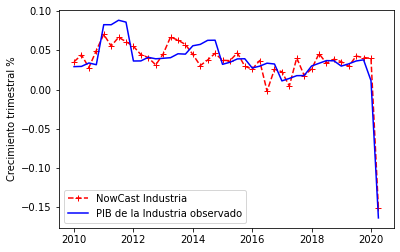

[ 0.0354  0.0442  0.028   0.0498  0.0704  0.0555  0.0666  0.061   0.0552  0.0446  0.0407  0.0314  0.0452  0.067
  0.063   0.0574  0.0448  0.0305  0.0377  0.0462  0.0373  0.0368  0.0467  0.0297  0.026   0.037  -0.0021  0.0259
  0.0226  0.0045  0.0404  0.0179  0.0261  0.0458  0.0335  0.0386  0.0356  0.0296  0.0427  0.0408  0.0398 -0.1518]


In [ ]:
X=np.array([ise,ipi,vent]).T
Y=np.array(pib)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg=LinearRegression()
reg=reg.fit(X,Y)
Y_pred=reg.predict(X)
#print(Y_pred)
#print(X)
#print(Y)
error=np.sqrt(mean_squared_error(Y,Y_pred))
r2=reg.score(X,Y)
z=reg.coef_
print("El error es: ", error)
print("The value of r2 is: ",r2)
print("The parameters are: \n'",reg.coef_)
ise1=-0.124
ipi1=-0.149
vent1=-0.158
#emp1=-0.045
#exp1=-3.76
#xm1=-0.12
#cement1=-0.221

print("GDP forecast in the third quarter 2019 is: \n",reg.predict([[ise1,ipi1,vent1]]))

#ise2=0.0124
#ipi2=-0.049
#vent2=0.058
#emp2=0.045
#exp2=0.176
#xm2=-0.042

#print("GDP forecast in the fourth quarter 2019 is: \n",reg.predict([[ise2,ipi2,vent2]]))

df=pd.DataFrame(datos)
plt.plot(tri,Y_pred,color='red',label="Pronostico PIB",linestyle='--',marker='+')
plt.plot(tri,pib,color='blue',label="Pronostico PIB",linestyle='-')
plt.ylabel('Crecimiento trimestral %')
plt.legend(['NowCast Industria','PIB de la Industria observado'])
plt.show()
print(Y_pred)

In [ ]:
X=np.array([xm,ipi]).T
Y=np.array(pib)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg=LinearRegression()
reg=reg.fit(X,Y)
Y_pred=reg.predict(X)
print(Y_pred)
print(X)
print(Y)
error=np.sqrt(mean_squared_error(Y,Y_pred))
r2=reg.score(X,Y)
z=reg.coef_
print("El error es: ", error)
print("The value of r2 is: ",r2)
print("The parameters are: \n'",reg.coef_)
#ise1=-0.124
ipi1=-0.149
#vent1=-0.158
#emp1=-0.045
#exp1=-3.76
xm1=-0.12

In [ ]:
import pandas as pd
datos=pd.read_excel('industria.xlsx','bdn')

## Se utilizan las variables de mayores correlaciones dinámicas
pib = datos['PIB']
now = datos['Nowcast Antioquia']     # Producción industrial
tri = datos['Time']

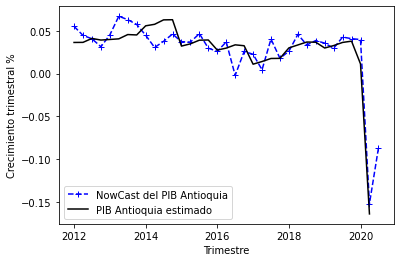

In [ ]:
#print("PIB Antioquia en el tercer trimestre: \n",-8.72%)
#print("PIB Industria cuarto trimestre: \n",reg.predict([[xm2,ipi2]]))
#print("Crecimiento Anual PIB Industria: \n",-0.1104)

df=pd.DataFrame(datos)
plt.plot(tri,now,color='blue',label="Pronostico PIB",linestyle='--',marker='+')
plt.plot(tri,pib,color='black',label="Pronostico PIB",linestyle='-')
plt.ylabel('Crecimiento trimestral %')
plt.xlabel('Trimestre')
plt.legend(['NowCast del PIB Antioquia','PIB Antioquia estimado'])
plt.show()

PIB Industria tercer trimestre: 
 [-0.1299]
PIB Industria segundo trimestre DANE: 
 -0.2541
PIB Industria cuarto trimestre: 
 [-0.0515]
Crecimiento Anual PIB Industria: 
 -0.1104


<function matplotlib.pyplot.show>

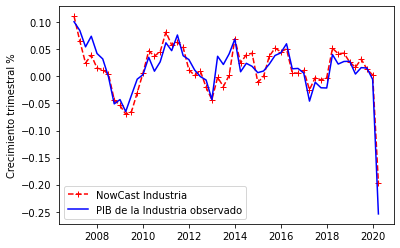

In [ ]:
print("PIB Industria tercer trimestre: \n",reg.predict([[xm1,ipi1]]))

ise2=0.0124
ipi2=-0.049
#vent2=0.058
#emp2=0.045
#exp2=0.176
xm2=-0.042
print("PIB Industria segundo trimestre DANE: \n",-0.2541)
print("PIB Industria cuarto trimestre: \n",reg.predict([[xm2,ipi2]]))
print("Crecimiento Anual PIB Industria: \n",-0.1104)

df=pd.DataFrame(datos)
plt.plot(tri,Y_pred,color='red',label="Pronostico PIB",linestyle='--',marker='+')
plt.plot(tri,pib,color='blue',label="Pronostico PIB",linestyle='-')
plt.ylabel('Crecimiento trimestral %')
plt.legend(['NowCast Industria','PIB de la Industria observado'])
plt.show

# ***Conclusiones***

---

La integración del nowcasting de la industria con índices coincidentes, sumado a la selección adecuada de los principales indicadores y variables macro del conjunto de información con las más altas correlaciones dinámicas y significativas desde el primer mes del año 2005 hasta el junio del 2020, en conjunto forman un modelo de diagnóstico de la industria en “tiempo pseudo real” por su actualización, siendo una herramienta rápida, con un alto nivel de precisión y de fácil aplicación por parte de los agentes económicos, eliminando las brechas de información que se presentan en la divulgación de datos de la industria en el país.


En los modelos nowcasting bajo el enfoque de dinámicos de factores encontró una proyección mensual del sector industrial PIB que mejora significativamente por la inclusión y el aumento del conjunto de información y el uso de las de mayor importancia en el modelo, que de forman conjunta proporciona estimaciones más precisas, rápidas y oportunas la Industria en Colombia, sin aumentar sustancialmente el error de revisión. Lo que sugiere que las técnicas de factores dinámicos podrían ser una parte importante del conjunto de herramientas de pronóstico macro sectoriales de países emergentes.


# ***Bibliografia***

•	Agrawal A., Gans J. & Goldfarb A. (2018). “Prediction Machines: The Simple Economics of Artificial Intelligence”, Harvard Business Review Press, abril 2018.

•	Amato L., Garegnani L. & Blanco E. (2016). Nowcasting de PIB: evaluando las condiciones cíclicas de la economía argentina. Ensayos Económicos del Banco central de la República de Argentina (BCRA), 1-20, December 2016.

•	Banbura, M., D. Giannone, M. Modugno, and L. Reichlin. (2013). “Nowcasting and the Real-Time Data Flow.” In G. Elliott and A. Timmermann, eds., Handbook of Economic Forecasting, Vol. 2. Amsterdam: Elsevier-North Holland.

•	Baquero, D. & González Manuel. (2019). A nowcasting model for Ecuador: Implementing a time-varying mean output growth. Journal Economic Modelling Volume 82, November 2019, Pages 250-263.

•	Bok, B., D. Caratelli, D. Giannone, A. Sbordone, and A. Tambalotti. (2017). “Macroeconomic Nowcasting and Forecasting with Big Data.” Federal Reserve Bank of New York Staff Reports, no. 830, November.

•	Bolhuis, A. & Rayner, B. (2020). Deus ex Machina? A Framework for Macro Forecasting with Machine Learning. IMF Working papers.

•	Casares, F. (2017). NOWCASTING: Modelos de factores dinámicos y ecuaciones puente para la proyección del PIB del ecuador. UM, ISSN Impresa 1390-8391, ISSN Online 1390-9894, Volumen 4, Nº 8, agosto, 2017.

•	Cepni, O., Güney, I. E., & Swanson, N. R. (2019). Nowcasting and forecasting GDP in emerging markets using global financial and macroeconomic diffusion indexes. International Journal of Forecasting, 35(2), 555-572.

•	Chakraborty, C. & Joseph, A. (2017). Machine learning at central banks. Staff Working Paper, 674, Bank of England.

•	Ferrara, L., & Marsilli, C. (2014). Nowcasting global economic growth: A factor-augmented mixed-frequency approach.

•	Foroni, C., & Marcellino, M. (2014). A comparison of mixed frequency approaches for nowcasting Euro area macroeconomic aggregates. International Journal of Forecasting, 30(3), 554-568.

•	Fornaro, P., & Luomaranta, H. (2020). Nowcasting Finnish real economic activity: a machine learning approach. Empirical Economics, 58(1), 55-71.

•	Giannone, D., Reichlin, L., & Small, D. (2008). Nowcasting: The real-time informational content of macroeconomic data. Journal of Monetary Economics, 55(4), 665-676.

•	González-Astudillo, M., & Baquero, D. (2019). A nowcasting model for Ecuador: Implementing a time-varying mean output growth. Economic Modelling, 82, 250-263.

•	Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: data mining, inference, and prediction. Springer Science & Business Media.

•	León, C. & Ortega, F. (2018). Nowcasting economic activity with electronic payments data: A predictive modeling approach. Borradores de economía, Núm.1037, 2018.

•	Liao, Yun (2017). Machine Learning in Macro-Economic Series Forecasting. International Journal of Economics and Finance; Vol. 9, No. 12; 2017.

•	Liu, P., Matheson, T., & Romeu, R. (2012). Real-time forecasts of economic activity for Latin American economies. Economic Modelling, 29(4), 1090-1098.

•	Stock, J. H., & Watson, M. W. (2006). “Forecasting With Many Predictors,” Handbook of Economic Forecasting, 1, 515–554.

•	Stock, J. H., & Watson, M. W. (2016). Dynamic factor models, factor-augmented vector autoregressions, and structural vector autoregressions in macroeconomics. In Handbook of macroeconomics (Vol. 2, pp. 415-525). Elsevier.

•	Smalter, A. (2018). “Machine Learning Approaches to Macroeconomic Forecasting,” Economic Review-Federal Reserve Bank of Kansas City, 103(4), 63.

•	Tiffin, A. (2016). Seeing in the dark: A machine-learning approach to nowcasting in Lebanon. IMF Working Paper, WP/16/56, International Monetary Fund.

•	Yaselga Alvarado, E. D. (2019). Un Indicador de Factores Dinámicos para la Evolución del PIB a Corto Plazo para el Ecuador. Cuestiones Económicas, 29(1).








---


---

